In [60]:
# default_exp data.load

In [61]:
# hide
import sys

sys.path.append("..")
import pandas as pd

In [62]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
import orjson

In [63]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 


## Data saving and restoring from json

In [64]:
# export
import numpy as np
import pandas as pd

In [65]:
# export
class TSMulti(MultiTuple):pass

In [66]:
# export
def get_df(length = [100,120]):
    dct = {'x':[],'con_ts_1':[],'con_ts_0':[],'cat_ts_1':[],'cat_ts_0':[],'con_0':[],'con_1':[], 'cat_0':[],'cat_1':[]}
    for i, l in enumerate(length):
        assert int(l/2) == l/2
        dct['x'].append(np.arange(l))
        dct['con_ts_0'].append(np.arange(l)[None,:])
        dct['con_ts_1'].append(pd.Series(np.arange(l)+np.random.randn(l)))
        dct['con_0'].append(np.random.rand()*2-1)
        dct['con_1'].append(10+np.random.rand()*2)
        dct['cat_ts_0'].append(L(['a','b']*int(l/2)))
        dct['cat_ts_1'].append(L(['david','john']*int(l/2)))
        dct['cat_0'].append(['a','b'][i%2])
        dct['cat_1'].append(['adam','rdam'][i%2])
    return pd.DataFrame(data=dct)   

In [67]:
df = get_df([10,12,6])
df

,x,con_ts_1,con_ts_0,cat_ts_1,cat_ts_0,con_0,con_1,cat_0,cat_1
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 0.141214 1 0.906210 2 0.970369 3 2.613945 4 4.254539 5 5.294362 6 6.321774 7 5.757063 8 8.756055 9 9.324644 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b]",0.436998,10.980725,a,adam
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]",0 0.861162 1 0.684330 2 1.554870 3 4.330805 4 3.012277 5 5.136544 6 6.835702 7 6.428286 8 5.839204 9 7.595309 10 9.710949 11 12.417875 dtype: float64,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]","[david, john, david, john, david, john, david, john, david, john, david, john]","[a, b, a, b, a, b, a, b, a, b, a, b]",0.425909,11.779051,b,rdam
2,"[0, 1, 2, 3, 4, 5]",0 0.417464 1 1.762250 2 2.514667 3 4.346518 4 3.700678 5 4.926550 dtype: float64,"[[0, 1, 2, 3, 4, 5]]","[david, john, david, john, david, john]","[a, b, a, b, a, b]",0.031874,10.975999,a,adam


In [68]:
# export
class Meta(dict):pass
class TS(dict):
    @classmethod
    def load(cls, f):
        return cls(orjson.loads(open(f,'rb').read()))
    
    def get_ts(self, meta:Meta, key):
        """Ensures it is always same order"""       
        try:
            return [self[key][o] for o in meta['col_names'][key+'_names']]       
        except KeyError:
            assert key in ['cat','con','ts_cat','ts_con']
            
    def get_np(self,meta:Meta, key):return np.array(self.get_ts(meta,key))            
    def __len__(self):return self['_length']
    
def get_ts_datapoint(f):
    return TS(orjson.loads(open(f,'rb').read()))

def get_meta(path:Path):
    classes = defaultdict(set)
    f = path / '.ts_meta'
    return Meta(json.load(open(f,'r')))        

In [69]:
path = Path('../data/test_data')
ts = TS.load(path / '1.json')
test_eq(set(ts.get_ts(get_meta(path), 'cat')),set(['rdam','b']))
test_close(ts.get_ts(get_meta(path), 'con'),[10,0], 2)
test_close(ts.get_np(get_meta(path), 'ts_con').shape,(3, len(ts)))
test_close(ts.get_np(get_meta(path), 'ts_cat').shape,(2, len(ts)))

In [70]:
# export
def python_type(o):
    if isinstance(o,int) or type(o) == np.int64:
        return int(o)
    elif isinstance(o,float) or type(o) == np.float64:
        if int(o) == o:
            return int(o)
        return float(o)
    elif type(o) == str:
        return o
    elif type(o) == pd.Series:
        return [python_type(v) for k,v in dict(o).items()]
    elif isinstance(o,list) or isinstance(o,L):
        return [python_type(v) for v in o]
    elif isinstance(o,np.ndarray):
        return [python_type(v) for v in list(o.flatten())]
    raise Exception(f"{type(o)}, {o}")
    

In [71]:
test_eq(python_type(np.array([0,0])),[0,0])
test_eq(type(python_type(np.array([1.,0.]))[0]),int)
test_eq(python_type(pd.Series(np.arange(10))),list(np.arange(10)))
test_eq(python_type(np.arange(10)[None,:]),list(np.arange(10)))

In [72]:
# export
def add_dct(dct, k, o):
    if type(o) == set:
        o = list(o)
        
    if type(o) == list or type(o) == L:
        if k in dct:
            dct[k] = list(set(dct[k] +o))
        else:
            dct[k] = o
    elif type(o) == dict or type(o) == collections.defaultdict:
        if k not in dct:
            dct[k] = {}            
        for _k,v in o.items():
            dct[k] = add_dct(dct[k], _k, v)
    elif type(o) == int or type(o) == float:
        dct[k] = o
    else:
        raise Exception(type(o))
    return dct

In [73]:
dct={'foo':'bar'}
dct = add_dct(dct, 'foo2',['bar2'])
test_eq(len(dct), 2)
dct = add_dct(dct, 'foodct',dict(a=1))
test_eq(dct['foodct'] , dict(a=1))
o = defaultdict(list)
o[1].append(0)
dct = add_dct(dct,'defaultdict',o )
test_eq(dct['defaultdict'][1],[0])

dct = add_dct(dct,'set',set([1,2,2]) )
test_eq(dct['set'],[1,2])

dct = add_dct(dct,'set2',{'set':set([1,2,2])} )
test_eq(dct['set2']['set'],[1,2])

In [74]:
# export
import json
def _check_length(lst, length):    
    if length is None:
        length = len(lst)
    else:
        assert len(lst) == length
    return length
        
def reconize_cols(datapoint:dict, con_names= [], cat_names=[], ts_con_names=[], ts_cat_names=[]):
    """Gets the con_names, cat_names, ts_con_names, ts_cat_names for the `datapoint`"""
    length = None
    classes = defaultdict(set)
    for k,v in datapoint.items():
        if k in [con_names+cat_names+ ts_con_names+ts_cat_names]:
            if k in [cat_names+ts_cat_names]:
                for _v in set(v):
                    classes[k].add(_v)
            continue
        if type(v) == int or isinstance(v,float):
            con_names.append(k)
        elif type(v) == str:
            cat_names.append(k)
            classes[k] = [v]
        elif isinstance(v,list) and (type(v[0]) == int or type(v[0]) == float):
            ts_con_names.append(k)
            length = _check_length(v, length)
        elif isinstance(v, list) and (type(v[0]) == str):
            ts_cat_names.append(k)
            length = _check_length(v, length)
            for _v in set(v):
                classes[k].add(_v)
        else:
            raise TypeError(type(v), type(v[0]))
    col_names = {k:list(set(v)) for k,v in zip('con_names, cat_names, ts_con_names, ts_cat_names'.split(', '),
                                         [con_names, cat_names, ts_con_names, ts_cat_names],)}
    return length, classes, col_names, [list(set(o)) for o in [con_names, cat_names, ts_con_names, ts_cat_names]]

def make_compact(dp, con_names, cat_names, ts_con_names, ts_cat_names, **kwargs):
    r = {'_'+k:v for k,v in kwargs.items()}  
    r['con'] = {k:dp[k] for k in con_names}
    r['cat'] = {k:dp[k] for k in cat_names}
    r['ts_con'] = {k:[float(i) for i in dp[k]] for k in ts_con_names}
    r['ts_cat'] = {k:dp[k] for k in ts_cat_names}
    return r
        
def meta_file(path, **kwargs):
    dct = {}
    f = path / '.ts_meta'
    if (path / '.ts_meta').exists():
        dct = json.load(open(f))
    for k,v in kwargs.items():
        dct = add_dct(dct,k,v)
    json.dump(dct, open(f,'w'), indent = 2, sort_keys = True)               

@delegates(reconize_cols)
def save_row(row, path:Path, fname='1', **kwargs):
    if not path.exists(): path.mkdir()
    if fname[-5:] is not '.json': fname += '.json'
    o = {k:python_type(v) for k,v in dict(row).items()}   
    length, classes, col_names, names = reconize_cols(o, **kwargs)  
    o = make_compact(o, *names, length = length)
    meta_file(path, classes=classes, col_names = col_names)
    open(path / fname,'wb').write(orjson.dumps(o, ))
    return path / fname

In [75]:
df = get_df([6])
path = Path('../data/test_data')
f = save_row(df.iloc[0,:], path)
dct = orjson.loads(open(f,'rb').read())
test_eq(dct['_length'],6)

In [76]:
# export
@delegates(save_row)
def save_df(df:pd.DataFrame, path:Path, **kwargs):
    for i, row in df.iterrows():
        save_row(row, path, fname=str(i), **kwargs)

In [77]:
df = get_df([600, 888, 1200])
path = Path('../data/test_data')
save_df(df, path)
[get_ts_datapoint(str(path / (str(i) + '.json'))).keys() for i in range(0,3)]

[dict_keys(['_length', 'con', 'cat', 'ts_con', 'ts_cat']),
 dict_keys(['_length', 'con', 'cat', 'ts_con', 'ts_cat']),
 dict_keys(['_length', 'con', 'cat', 'ts_con', 'ts_cat'])]

## Transform catagorical data

In [78]:
# export
def _get_classes(df, cat_cols, classes=None):    
    classes = ifnone(classes, {})
    if classes == {}:
        for col in cat_cols:
            classes[col] = unpack_list(list(df[col]))
    return classes

def _make_vocab_df(df,cat_cols, classes = None):
    vocab,o2i = {},{}
    classes = _get_classes(df, cat_cols, classes)
    for col, vals in classes.items():
        vocab[col], o2i[col] = uniqueify(vals, sort=True, bidir=True)
    return vocab, o2i

In [79]:
# export
class TensorCatI(TensorBase):pass
class CatSeqI(TensorSeq):pass
def unpack_list(o, r=None):
    r = ifnone(r,L())
    for a in o:
        if isinstance(a,list) or isinstance(a,L):
            r = unpack_list(a, r)
        else:
            r.append(a)
    return r
            
class CatTfm(Transform):
    def __init__(self, df:pd.DataFrame = None, cat_cols:[] = None,
                 classes = None, vocab=None, o2i=None):
        if vocab is not None and o2i is not None:
            self.vocab,self.o2i = vocab, o2i
        else:
            self.vocab,self.o2i = _make_vocab_df(df,cat_cols)
        
            
    def encodes(self, x: TensorCat):
        r = []
        for i, (o, key) in enumerate(zip(x.o, x._meta['label'])):
            r.append(self.o2i[key][o])#TensorCat   
        return TensorCatI(r, label = x._meta['label'])
    
    def decodes(self, x:TensorCatI): 
        r = []
        for i,(o, key) in enumerate(zip(x,x._meta['label'])):
            r.append(self.vocab[key][o]) #TensorCat   
        return TensorCat(r, label = x._meta['label'])
    
    def encodes(self, x:CatSeq):
        r = []
        for i,(o, key) in enumerate(zip(x.o,x._meta['label'])):
            r.append([])
            for a in o: 
                r[i].append(self.o2i[key][a]) #CatSeq        
        return CatSeqI(r, label = x._meta['label'])
    
    def decodes(self, x:CatSeqI):
        r = []        
        for i, (o, key) in enumerate(zip(x,x._meta['label'])):
            r.append([])
            for a in o:
                r[i].append(self.vocab[key][a])  
        return CatSeq(r, label = x._meta.get('label',None))
    
    

In [80]:
vocab = {'cat_0':['a','b'],'cat_1':['adam','rdam'],'cat_ts_0':['a','b'],'cat_ts_1': ['david','john']}
tfm = CatTfm(vocab = vocab,
             o2i = {'cat_0': {'a': 0, 'b': 1},
                     'cat_1': {'adam': 0, 'rdam': 1},
                     'cat_ts_0': {'a': 0, 'b': 1},
                     'cat_ts_1': {'david': 0, 'john': 1}})
test_eq(tfm.vocab, vocab)

In [81]:
o = TensorCat(['a','adam'], label=['cat_0','cat_1'])
test_eq(tfm.encodes(o),tensor([0,0]))
o = CatSeq([['a'],['david']], label=['cat_ts_0','cat_ts_1'])
test_eq(tfm.encodes(o),tensor([[0],[0]]))

In [82]:
test_eq(tfm.decode(TensorCatI([0,0], label=['cat_0','cat_1'])), 
        TensorCat(['a','adam'], label=['cat_0','cat_1']) )

test_eq(tfm.decode(CatSeqI([[0],[0]], label=['cat_ts_0','cat_ts_1'])),
       CatSeq([['a'],['david']], label=['cat_ts_0','cat_ts_1']))
tfm.decode(CatSeqI([[0],[0]], label=['cat_ts_0','cat_ts_1']))

CatSeq([['a'], ['david']], label = ['cat_ts_0', 'cat_ts_1'])

In [83]:
o = CatSeq([['y','z','z','z'],['adam','rdam','adam','rdam']], label = ['cat_ts_1', 'cat_ts_0'])
df = pd.DataFrame({'cat_ts_1':[[i] for i in 'xzy'],'cat_ts_0':[[i] for i in ['adam','rdam','adam']],
                   'cat':['john','john','david'], 'cat1':['_john','_john','_david']})
tmf = CatTfm(df, ['cat_ts_0','cat_ts_1','cat','cat1'])
tmf(o)
o = TensorCat(['david','_john'], label = ['cat','cat1'])
tmf(o)

TensorCatI([0, 1])

In [84]:
df = pd.DataFrame({'a':[[i,'a'] for i in 'aabb']})
tmf = CatTfm(df, ['a'], {})
print(tmf.vocab)

{'a': (#2) ['a','b']}


In [85]:
o = CatSeq([['a','b','a','a']], label='a')
o_tmf = tmf(o)
test_eq(o_tmf, TensorCatI([[0, 1, 0, 0]]))
test_eq(o_tmf._meta['label'], 'a')
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeq([['a', 'b', 'a', 'a']], label = ['a'])

In [86]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a'], label='a'))
test_eq_type(o_tmf,TensorCatI([0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a'],label = 'a'))

o_tmf = tmf(TensorCat(['b'], label='a'))
test_eq_type(o_tmf,TensorCatI([1]))
test_eq(tmf.decode(o_tmf),TensorCat(['b'],label='a'))

In [87]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b'], label = ['a','a_2']))
test_eq_type(o_tmf,TensorCatI([0,0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b'],label = 'a'))

In [88]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o = CatSeq([['a','b','a','a'],['b','b','c','c']], label=['a','a_2'])
o_tmf = tmf(o)
test_eq(o_tmf, CatSeqI([[0, 1, 0, 0],
                        [0, 0, 1, 1]]))
test_eq(o_tmf._meta['label'], ['a','a_2'])
dec_o = tmf.decode(o_tmf)
test_eq(dec_o,o)
dec_o

CatSeq([['a', 'b', 'a', 'a'], ['b', 'b', 'c', 'c']], label = ['a', 'a_2'])

# Dataloader

## make_ids

In [89]:
# export
def get_classes(path:Path):
    return get_meta(path)['classes']
                    
def make_vocab(path, classes = None):
    if classes is None:
        classes = get_classes(path)
    vocab, o2i = {},{}
    for col, vals in classes.items():
        vocab[col], o2i[col] = uniqueify(vals, sort=True, bidir=True)
    return vocab, o2i

In [90]:
df = get_df([600, 888, 1200])
path = Path('../data/test_data')
save_df(df, path)
get_classes(path)

{'cat_0': ['a', 'b'],
 'cat_1': ['rdam', 'adam'],
 'cat_ts_0': ['a', 'b'],
 'cat_ts_1': ['john', 'david']}

In [91]:
make_vocab(path)[0]

{'cat_0': (#2) ['a','b'],
 'cat_1': (#2) ['adam','rdam'],
 'cat_ts_0': (#2) ['a','b'],
 'cat_ts_1': (#2) ['david','john']}

In [92]:
# export
def make_ids(dl):  
    """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
    # Slice each time series into examples, assigning IDs to each
    last_id = 0
    n_dropped = 0
    n_needs_padding = 0
    dl._ids = {}
    for f in dl.dataset:
        dp = get_ts_datapoint(f)  
        num_examples = (dp['_length'] - dl.lookback - dl.horizon + dl.step) // dl.step
        # Time series shorter than the forecast horizon need to be dropped.
        if dp['_length'] < dl.min_seq_len:
            n_dropped += 1
            continue
        # For short time series zero pad the input
        if dp['_length'] < dl.lookback + dl.horizon:
            n_needs_padding += 1
            num_examples = 1
        for j in range(num_examples):
            dl._ids[last_id + j] = (str(f), j * dl.step)
        last_id += num_examples

    # Inform user about time series that were too short
    if n_dropped > 0:
        print("Dropped {}/{} time series due to length.".format(
                n_dropped, len(dl.dataset)))

    # Inform user about time series that were short
    if n_needs_padding > 0:
        print("Need to pad {}/{} time series due to length.".format(
                n_needs_padding, len(dl.dataset)))
    # Store the number of training examples
    dl.n = int(dl._ids.__len__() )
    return dl, dl.n
    

In [93]:
# needs a test

## get_part_of_ts

In [94]:
# export
@typedispatch
def get_part_of_ts(x, lookback_id, length, pad=np.mean, t = tensor, **kwargs):
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = t(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        ), **kwargs).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = t(x[:,lookback_id:lookback_id + length], **kwargs).float()
    return x


In [95]:
x = np.vstack([np.arange(10.)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10.)[None,:]
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [96]:
# hide
x = np.arange(10.)[None,:]
o =get_part_of_ts(x, 0, 11, t = TensorBase, label='a')
test_eq_type(o, TensorBase([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])) 
test_eq(o._meta, {'label':'a'})

In [97]:
# export
@typedispatch
def get_part_of_ts(x:list, lookback_id, length, t = L, **kwargs):
    if len(x[0]) < length:
        # If the time series is too short, we pad
        padding = [o[-1] for o in x]
        pad_len = length - len(x[0])
        x = [o[lookback_id:lookback_id + length] + [padding[i]]*pad_len for i,o in enumerate(x)]
    else:
        x = [o[lookback_id:lookback_id + length] for o in x]
    return t(x, **kwargs)

@typedispatch
def get_part_of_ts(x:L, *args, **kwargs):
    return get_part_of_ts(list(x),*args, **kwargs)

In [98]:
x = L(['a','b']*5,['z','x']*5)
o =get_part_of_ts(x, 1, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [99]:
x = L(['a','b']*2, ['z','x']*2)
o =get_part_of_ts(x, 0, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [100]:
# hide
x = [[1,2]*2, [10,11]*2]
o =get_part_of_ts(x, 0, 5, t = TensorSeq)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),TensorSeq)

## get_id

In [101]:
# export
def split_ts_con(ts, y_name, meta:Meta):  
    ts_con_names = [o for o in meta['col_names']['ts_con_names'] if o != y_name]
    y = ts['ts_con'][y_name]
    tsx = [ts['ts_con'][k] for k in ts_con_names]
    return y, tsx, ts_con_names
    

def json2TSMulti(ts, lookback_id, y_name, lookback, horizon, meta:Meta):
    y, tsx, ts_con_names = split_ts_con(ts, y_name, meta)
    
    y = get_part_of_ts([y], lookback_id, lookback + horizon,
                       t = TensorSeq, label=[y_name + '_y'], m=['g'])
    x = TensorSeq(y[:,:lookback], label=[y_name + '_x'], m=['g'])
    tsx_con = get_part_of_ts(tsx, lookback_id, lookback + horizon,
                             t = TensorSeq, label=ts_con_names)
    tsx_cat = get_part_of_ts(ts.get_ts(meta,'ts_cat'), lookback_id, lookback + horizon,
                             t = CatSeq, label=meta['col_names']['ts_cat_names'])        
    r = [x, tsx_con, tsx_cat]
    r.append(TensorCat(ts.get_ts(meta,'cat'), label=meta['col_names']['cat_names']))
    r.append(TensorCon(ts.get_ts(meta,'con'), label=meta['col_names']['con_names']))      
    r.append(y)
    return TSMulti(r)

In [102]:
df = get_df([2000, 2000, 2000])
path = Path('../data/test_data')
save_df(df, path)

In [106]:
ts = get_ts_datapoint('../data/test_data/1.json')
r = json2TSMulti(ts, 1000, 'x',100, 10, get_meta(path))
test_eq(len(r), 6)
print({str(type(a))+str(i):a.shape for i,a in enumerate(r)})

{"<class 'fastseq.core.TensorSeq'>0": torch.Size([1, 100]), "<class 'fastseq.core.TensorSeq'>1": torch.Size([2, 110]), "<class 'fastseq.core.CatSeq'>2": (2, 110), "<class 'fastseq.core.TensorCat'>3": (2,), "<class 'fastseq.core.TensorCon'>4": torch.Size([2]), "<class 'fastseq.core.TensorSeq'>5": torch.Size([1, 110])}


## Multi Tfm

In [107]:
# export
class TSMulti_(Tuple):
    def print_dict(self):
        return {str(str(i)+'_'+type(a)):a.shape for i,a in enumerate(self)}

class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, **kwargs): # maybe change to proccs
        self.f = CatTfm(**kwargs)
        
    def encodes(self, o):
        return TSMulti_(self.f(a) for a in o)
    
    def decodes(self, o): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [56]:
df = get_df([14,14,16])
save_df(df, path)
path = Path('../data/test_data')
o = json2TSMulti(get_ts_datapoint(get_files(path,extensions='.json')[0]), 0, 'x', 10, 3, get_meta(path))

vocab,o2i = make_vocab(get_files(path,extensions='.json'), get_meta(path)['classes'])
t = CatMultiTfm(vocab = vocab, o2i=o2i)

o_tmf = t(o)
test_eq_type(o_tmf[2], CatSeqI([[o2i[k][a] for a in v] for k,v in o[2].dict().items()],
                               label = ['cat_ts_1', 'cat_ts_0']))
test_eq(type(o_tmf[3]), type(TensorCatI([0,0])))

o_b = t.decodes(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))

In [57]:
# hide
# test the other route is still working
df = get_df([14,14])
Mtmf = CatMultiTfm(df=df, cat_cols=['cat_ts_1', 'cat_ts_0', 'cat_0','cat_1'])
o = TSMulti(TensorBase([1]), TensorCat(['adam','b'], label=['cat_1','cat_0']), 
            CatSeq([['david','david'],['a','b']], label=['cat_ts_1','cat_ts_0']))
o_tmf = Mtmf.encodes(o)
test_eq(o_tmf,TSMulti_(TensorBase([1]), TensorCatI([0,1]), CatSeqI([[0,0],[0,1]])))
o_b = Mtmf.decodes(o_tmf)
test_eq(o_b, o)
test_eq(type(o_b), type(TSMulti(1)))


## Dataloader

In [67]:
# export
class MTSDataLoader(TfmdDL):    
    @delegates(TfmdDL.__init__)
    def __init__(self, dataset, meta:Meta, y_name = 'x', lookback=14, horizon=7, step=1, min_seq_len=None,
                train = True, procs = None, vocab=None, o2i=None, **kwargs):
        assert type(meta) == Meta or type(meta) == dict
        store_attr(self,'dataset,y_name,lookback,horizon,step,meta')
        self.min_seq_len = ifnone(min_seq_len, lookback) 
        self, n = make_ids(self)
        if vocab is None: # from MTSDataLoaders
            vocab, o2i = make_vocab(dataset, classes = self.meta['classes'])
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(vocab = vocab, o2i=o2i))        
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(L(procs))
        self.procs.setup(self, train)
        
    @delegates(__init__)
    @classmethod
    def from_path(cls, path, **kwargs):
        return cls(get_files(path, extensions='.json'), get_meta(path),**kwargs)
    
    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['meta','horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res, n = make_ids(res)
        res.n = n        
        return res    
    
    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        fpath, lookback_id = self._ids[idx]
        ts = get_ts_datapoint(fpath)
        return json2TSMulti(ts, lookback_id, self.y_name, self.lookback, self.horizon, self.meta)         
    

In [62]:
df = get_df([2000, 500, 6])
save_df(df, path)
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2, num_workers = 0)

for o in dl:
    assert o[0].shape[1:] == (1,10), o[0].shape
    assert o[0].shape[1:] == (1,10), o[0].shape

Dropped 1/3 time series due to length.


# Showing

In [63]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

MTSDataLoader.show_batch = _show_batch_class

In [64]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeq, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [65]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeq) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

Dropped 1/3 time series due to length.


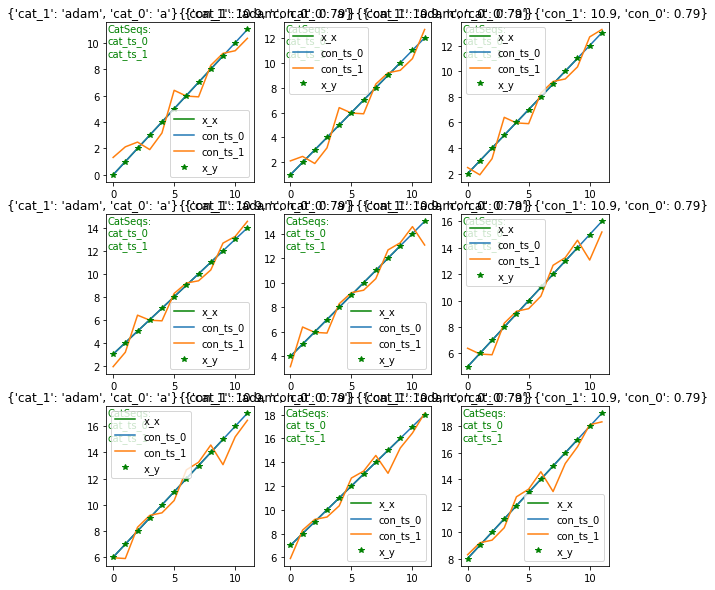

In [66]:
horizon,lookback = 2,9
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2,)
dl.show_batch()

In [67]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [68]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [69]:
a = TensorSeq([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,45989545115648.0,4.331696567825203e+16,'00:00']


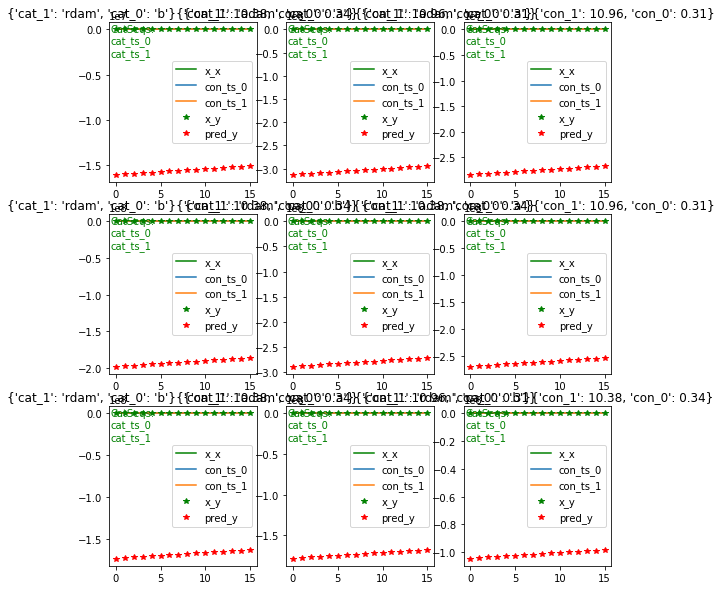

In [70]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.ones(in_f,in_f+out_f)), nn.Parameter(torch.zeros(in_f+out_f))
    def forward(self, x,*args): 
        assert x.shape[1:] == (1,10), x
        return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)

horizon,lookback = 6, 10
df = get_df([160, 160, 160])
save_df(df, path)
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)

learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))
learn.fit(1)
learn.show_results(max_n=9)

(#4) [0,4.322500097951662e+17,1.4532075947485645e+21,'00:00']


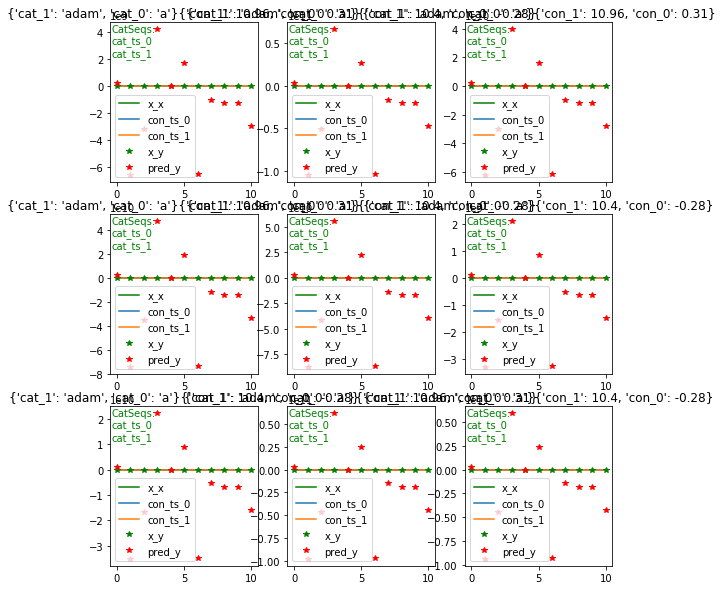

In [71]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)
learn.show_results(max_n=9)

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_m5.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_data.m5.ipynb.


In [34]:
git_add('02_data.load.ipynb', commit_msg='better w/ nested sets')

Converted 02_data.load.ipynb.


['/home/tako/dev/fastseq/fastseq/data/load.py',
 '/home/tako/dev/fastseq/nbs/02_data.load.ipynb']

In [44]:
900/60

15.0

In [47]:
len(list(Path('../data/m5/rows').glob('*.json')))

24584